In [17]:
#system lib imports
import os 
import re
from dataclasses import dataclass
from typing import Dict, List
from enum import Enum

#third party lib imports
import skfda
import skfda.representation.basis as basis
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
import pyedflib
import numpy as np 
import matplotlib.pyplot as plt

from skfda.representation.basis import BSplineBasis
from skfda.representation.interpolation import SplineInterpolation
from scipy import stats 
from scipy.special import exp10 as exp10

#NOTE: dataset needs to be downloaded and unziped  

#filter edf files
eeg_signalfiles_names = list(filter(lambda s : s.endswith(".edf") , 
                            [os.path.abspath(os.path.join("../data/eeg-during-mental-arithmetic-tasks-1.0.0", f)) for 
                            f in os.listdir("../data/eeg-during-mental-arithmetic-tasks-1.0.0")]
                        ))

#dicts with subject_id - eeg_signal_filepath
before_arith_task = {}
after_arith_task = {}

# process each file
for edf_file_name in eeg_signalfiles_names :
    file_name = os.path.basename(edf_file_name)
    
    # extract subject identifier and suffix
    if "_1.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        before_arith_task[subject_id] = edf_file_name
    
    elif "_2.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        after_arith_task[subject_id] = edf_file_name

In [18]:
print("len of dict bat: ",len(before_arith_task.keys()))
print("len of dict aat: ",len(after_arith_task.keys()))

len of dict bat:  36
len of dict aat:  36


In [19]:
label_index_dict = {"Fp1":0,"Fp2":1,"F3":2,"F4":3,"F7":4,"F8":5,"T3":6,"T4":7,"C3":8,
                    "C4":9,"T5":10,"T6":11,"P3":12,"P4":13,"O1":14,"O2":15,"Fz":16, "Cz":17,"Pz":18}

In [20]:
class TimePeriod(Enum):
    BEFORE = "before"
    AFTER = "after"
    
@dataclass
class EEGData:
        subject_id: int
        data_matrix: np.matrix
        fs_eeg_signals: np.float64
        time_period: TimePeriod


In [21]:
f = pyedflib.EdfReader(before_arith_task[0])

#print edf file metadata
print(f.file_info_long())
eeg_signal = f.readSignal(label_index_dict.get("T4", None))
sample_fs = f.getSampleFrequencies()
num_samples = f.getNSamples()

f.close()
print("fs: ", sample_fs[0])
print("num samples: ", num_samples)
print("eeg signal number 0: ", eeg_signal)

file name: /home/enki/Documents/THESIS/FDA-EEG/data/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf
signals in file: 21
label: EEG Fp1 fs: 500.0 nsamples 91000
label: EEG Fp2 fs: 500.0 nsamples 91000
label: EEG F3 fs: 500.0 nsamples 91000
label: EEG F4 fs: 500.0 nsamples 91000
label: EEG F7 fs: 500.0 nsamples 91000
label: EEG F8 fs: 500.0 nsamples 91000
label: EEG T3 fs: 500.0 nsamples 91000
label: EEG T4 fs: 500.0 nsamples 91000
label: EEG C3 fs: 500.0 nsamples 91000
label: EEG C4 fs: 500.0 nsamples 91000
label: EEG T5 fs: 500.0 nsamples 91000
label: EEG T6 fs: 500.0 nsamples 91000
label: EEG P3 fs: 500.0 nsamples 91000
label: EEG P4 fs: 500.0 nsamples 91000
label: EEG O1 fs: 500.0 nsamples 91000
label: EEG O2 fs: 500.0 nsamples 91000
label: EEG Fz fs: 500.0 nsamples 91000
label: EEG Cz fs: 500.0 nsamples 91000
label: EEG Pz fs: 500.0 nsamples 91000
label: EEG A2-A1 fs: 500.0 nsamples 91000
label: ECG ECG fs: 500.0 nsamples 91000
None
fs:  500.0
num samples:  [91000 91000 910

In [22]:
def eeg_dataclass(
    subject_idx: int, 
    subject_edfsignal_dict: Dict[int, str], 
    labels: List[str],
    time_period: TimePeriod
    ) -> EEGData:
    if subject_edfsignal_dict.get(subject_idx,-1) == -1:
        raise KeyError
    
    #concatenate eeg signals into a data matrix
    with pyedflib.EdfReader(subject_edfsignal_dict[subject_idx]) as f:
        eeg_signals_arr = []
        for label in labels:
            idx = label_index_dict.get(label,-1)
            if idx == -1:
               raise KeyError
            eeg_signal = f.readSignal(idx)
            eeg_signals_arr.append(eeg_signal)
        sample_fs = f.getSampleFrequencies()
        f.close()
        data_matrix = np.matrix(eeg_signals_arr)

        #build dataclass instance
        eeg_data = EEGData(
        subject_id=subject_idx,
        data_matrix= data_matrix,
        fs_eeg_signals=sample_fs[0],
        time_period = time_period
        )    
        return eeg_data

In [32]:
all_labels = list(label_index_dict.keys())
data = eeg_dataclass(0, before_arith_task, all_labels, TimePeriod.BEFORE)
print(data.data_matrix)

print(data.data_matrix.shape)

[[-3.64793763e+00 -4.23648168e+00 -4.95421832e+00 ...  1.35446677e-03
   1.35446677e-03  1.35446677e-03]
 [-3.58186632e+00 -4.27938829e+00 -5.02084864e+00 ... -8.87424125e-04
  -8.87424125e-04 -8.87424125e-04]
 [-4.08124663e+00 -4.76621934e+00 -5.78345493e+00 ...  4.75066606e-04
   4.75066606e-04  4.75066606e-04]
 ...
 [-2.27750564e-01 -6.02733003e-01 -1.16329348e+00 ...  1.83052110e-03
   1.83052110e-03  1.83052110e-03]
 [ 3.58397147e-01  4.16035068e+00  8.86106535e+00 ... -4.60712749e-04
  -4.60712749e-04 -4.60712749e-04]
 [ 2.82213640e+00  5.31172705e+00  8.36727827e+00 ...  2.82381323e-04
   2.82381323e-04  2.82381323e-04]]
(19, 91000)


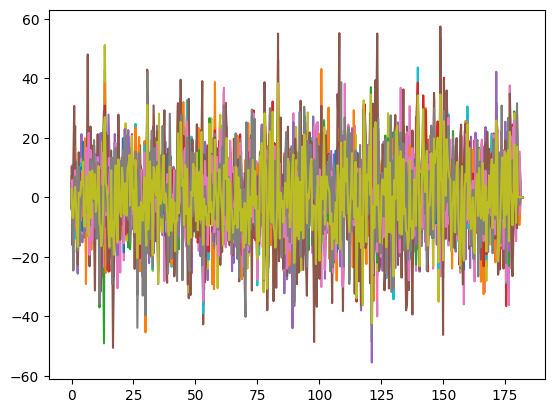

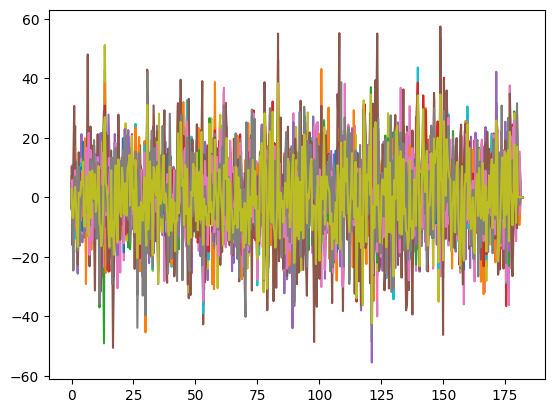

In [24]:
#raw eeg-signals transformed into discrete functional data using 
#B-splines basis functions

fd = skfda.FDataGrid(
            data_matrix=data.data_matrix,
            grid_points=np.linspace(0,num_samples[0],num_samples[0])/sample_fs[0]
        )
n_basis = 19

fd.plot()

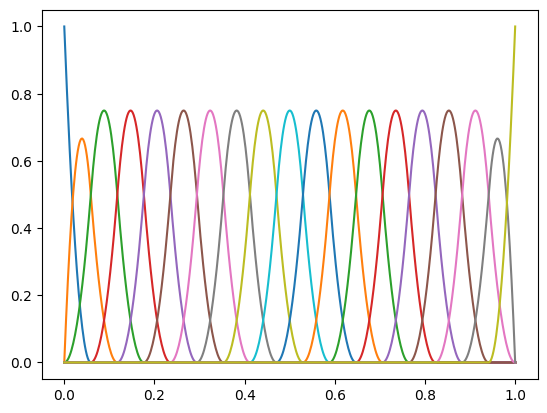

In [25]:
#plot b-spline basis
bspline_basis = skfda.representation.basis.BSplineBasis(n_basis=n_basis, order=3)
bspline_basis.plot()
plt.show()

In [33]:
def convert_raweeg_2fd(
    eeg_data: EEGData, 
    n_basis: int, 
    save_plot: bool = False
    ) -> skfda.FDataBasis:
    
    data = eeg_data.data_matrix
    #functional data in dicrete format
    fd = skfda.FDataGrid(
            data_matrix= data,
            grid_points= np.linspace(0, data.shape[1], data.shape[1])/eeg_data.fs_eeg_signals
        )

    #raw eeg-signals transformed into functional data using B-splines basis functions
    fd_basis = fd.to_basis(basis.BSplineBasis(n_basis=n_basis))
    
    return fd_basis

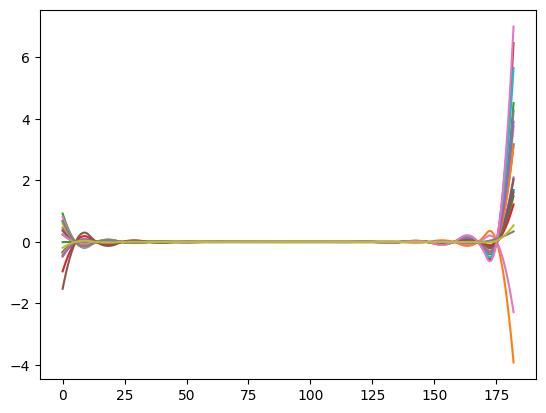

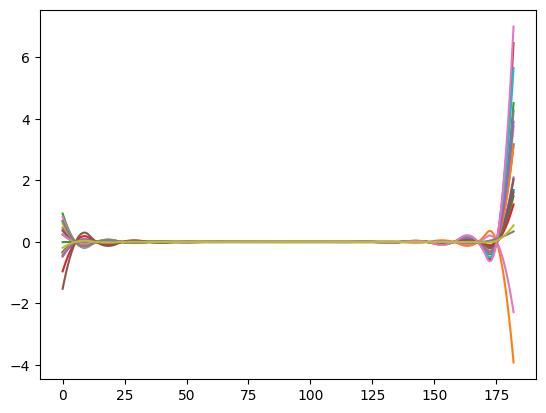

In [34]:
#plot of functional data transformed into truncated basis-functions format using
#B-splines basis functions
fd_basis = fd.to_basis(basis.BSplineBasis(n_basis=n_basis, order=3))

fd_basis.plot()

In [ ]:
[2.35103996e+02, 1.18188352e+01, 1.06647966e-01, 1.33301302e-03,
 1.30856221e-04, 1.16865316e-04, 7.21625196e-05, 4.85930309e-05,
 1.90097533e-05, 9.86483979e-06, 3.97611563e-06, 1.86405478e-06,
 1.41652843e-06, 3.98489175e-07, 2.63442227e-07, 1.60203596e-07,
 9.23368619e-09, 5.75135685e-09, 1.90812622e-34]

[2.35103996e+02 1.18188352e+01 1.06647966e-01 1.33301302e-03
 1.30856221e-04 1.16865316e-04 7.21625196e-05 4.85930309e-05
 1.90097533e-05 9.86483979e-06 3.97611563e-06 1.86405478e-06
 1.41652843e-06 3.98489175e-07 2.63442227e-07 1.60203596e-07
 9.23368619e-09 5.75135685e-09]


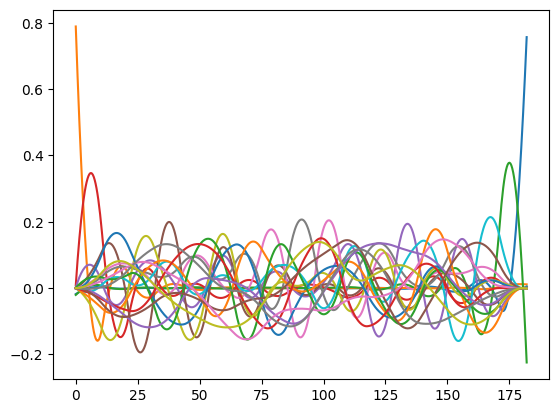

In [42]:
#plot of the first 19 principal components and its associated eigvals
fpca = FPCA(n_basis)
fpca.fit(fd_basis)
fpca.components_.plot()

eigvals = np.square(fpca.singular_values_)
eigvals = eigvals[np.abs(eigvals) >= np.finfo(float).eps] #filter eigenvalues less than machine epsilon

print(eigvals)

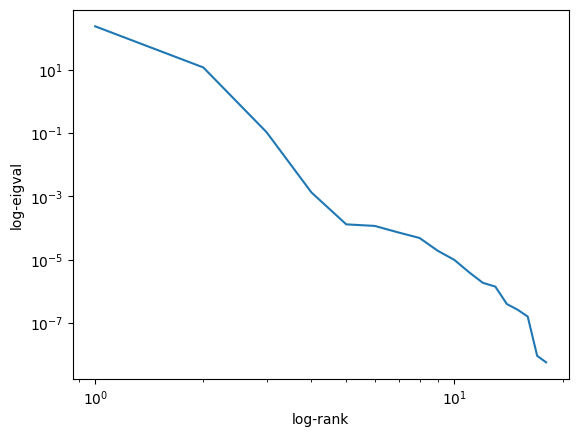

In [44]:
#ranks vs eigspectrum in loglog scale
ranks = np.arange(1, len(eigvals) + 1)
plt.loglog(ranks, eigvals)

#label axes
plt.xlabel('log-rank')
plt.ylabel('log-eigval')

#show plot
plt.show()

r**2:  0.9683954330591313


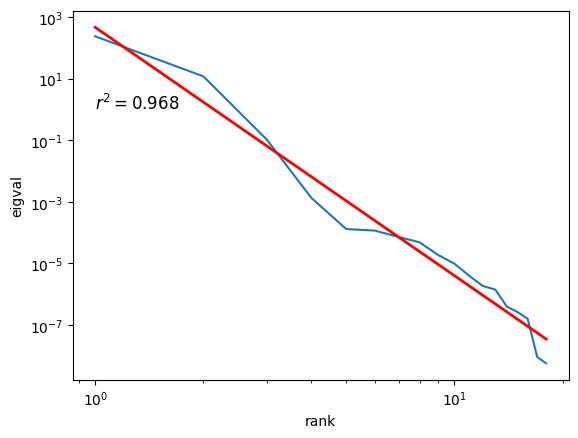

In [45]:
#slope, intercept
slope, intercept, r, p, se = stats.linregress(np.log10(ranks), 
    np.log10(eigvals))

print("r**2: ", r**2)

ols_power_law = lambda x: 10**(intercept + np.log10(x)*slope)

vals = list(map(ols_power_law, ranks))

ranks = np.arange(1,len(eigvals) + 1)

plt.loglog(ranks, eigvals)
plt.plot(ranks, vals, label=f'Fit: y = {10**intercept:.2f} * x^{slope:.2f}', color='red', linewidth=2)
plt.text(1, 1, f"$r^2 = {r**2:.3f}$", fontsize=12, color="black")

#label axes
plt.xlabel('rank')
plt.ylabel('eigval')

#show plot
plt.show()